# Import Required Libraries
Import necessary libraries such as TensorFlow, Keras, NumPy, and Matplotlib.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
import os
from PIL import UnidentifiedImageError


/Users/Thomas/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Set Hyperparameters
Define hyperparameters including resolution of image, number of convolution layers, batch size, and epochs.

In [21]:
# Define hyperparameters
# image_resolution = (128, 128)  # Resolution of image
image_resolution = (64, 64)  # Resolution of image
num_conv_layers = 3  # Number of convolution layers
# batch_size = 32  # Batch size
batch_size = 16  # Batch size
epochs = 2  # Number of epochs

# Define file paths
train_data_dir = 'concrete_crack_images/training'
test_data_dir = 'concrete_crack_images/test'

# Define categories
categories = ['Negative', 'Positive']


# Load and Preprocess Data
Load images from the local file path, split them into training and test sets, and preprocess them (resize, normalize).

In [ ]:
# Function to load images and labels for training data
def load_data_with_error_handling(data_dir, categories, image_resolution):
    images = []
    labels = []
    for category in categories:
        category_path = os.path.join(data_dir, category)
        if not os.path.exists(category_path):
            print(f"Directory {category_path} does not exist.")
            continue
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            try:
                img = load_img(img_path, target_size=image_resolution)
                img_array = img_to_array(img)
                images.append(img_array)
                labels.append(categories.index(category))
            except UnidentifiedImageError:
                print(f"Cannot identify image file {img_path}. Skipping.")
    return np.array(images), np.array(labels)

# Function to load images for test data
def load_test_data_with_error_handling(data_dir, image_resolution):
    images = []
    if not os.path.exists(data_dir):
        print(f"Directory {data_dir} does not exist.")
        return np.array(images)
    for img_name in os.listdir(data_dir):
        img_path = os.path.join(data_dir, img_name)
        try:
            img = load_img(img_path, target_size=image_resolution)
            img_array = img_to_array(img)
            images.append(img_array)
        except UnidentifiedImageError:
            print(f"Cannot identify image file {img_path}. Skipping.")
    return np.array(images)


In [16]:
# Load training data
X_train, y_train = load_data_with_error_handling(train_data_dir, categories, image_resolution)

# Load test data with labels
X_test = load_test_data_with_error_handling(test_data_dir, image_resolution)

# Print shapes of the datasets
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")


Training data shape: (32107, 64, 64, 3)
Test data shape: (7893, 64, 64, 3)
Training labels shape: (32107,)


# Build the Convolutional Neural Network (CNN)
Create a CNN model with the specified number of convolution layers.

In [17]:
# Build the Convolutional Neural Network (CNN)

# Define the initial number of filters
initial_filters = 32
dropout_rate = 0.5  # Dropout rate (50% of the units will be dropped)

# Initialize the CNN model
model = Sequential()

# Add convolutional layers based on the specified number of convolution layers
for i in range(num_conv_layers):
    filters = initial_filters * (2 ** i)
    if i == 0:
        # First layer needs to specify input shape
        model.add(Conv2D(filters, (3, 3), activation='relu', padding="same", input_shape=(image_resolution[0], image_resolution[1], 3)))
    else:
        model.add(Conv2D(filters, (3, 3), activation='relu', padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))

# Add dropout layer after the fully connected layer
model.add(Dropout(dropout_rate))

# Flatten the output from the convolutional layers
model.add(Flatten())

# Add a fully connected layer
model.add(Dense(128, activation='relu'))

# Add the output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,142,081 (4.36 MB)

 Trainable params: 1,142,081 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

# Train the Model
Train the CNN model using the training data and specified batch size, and record the computational time.

Epoch 1/2
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 45s 28ms/step - accuracy: 0.9843 - loss: 0.0544 - val_accuracy: 0.9749 - val_loss: 0.0952
Epoch 2/2
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 45s 28ms/step - accuracy: 0.9866 - loss: 0.0427 - val_accuracy: 0.9872 - val_loss: 0.0387
Training Time: 91.49 seconds


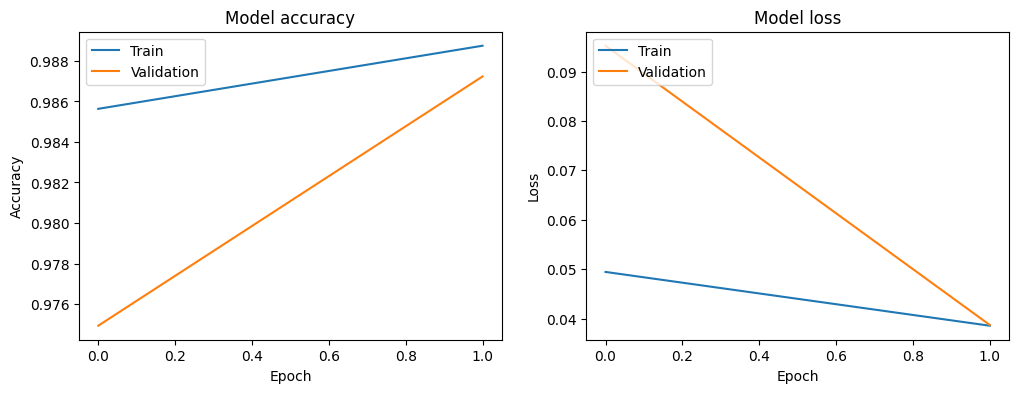

In [22]:
# Train the Model

# Split the training data into training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Start the timer
start_time = time.time()

# Train the model with validation data
history = model.fit(X_train_split, y_train_split, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1)

# End the timer
end_time = time.time()

# Calculate the computational time
training_time = end_time - start_time

# Print the computational time
print(f"Training Time: {training_time:.2f} seconds")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Evaluate the Model
Evaluate the model using the test data and calculate accuracy.

In [25]:
# Evaluate the Model

# Calculate the computational time for evaluation
evaluation_start_time = time.time()

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)

evaluation_end_time = time.time()
evaluation_time = evaluation_end_time - evaluation_start_time

# Print the computational time for evaluation
print(f"Evaluation Time: {evaluation_time:.2f} seconds")

# Print the test accuracy
print(f"Test Accuracy: {test_accuracy:.2f}")

# Print the test loss
print(f"Test Loss: {test_loss:.2f}")


ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 7893
'y' sizes: 0


# Display Results
Display the training and test accuracy, and the computational time.

In [ ]:
# Display Results

# Display the training accuracy
training_accuracy = history.history['accuracy'][-1]
print(f"Training Accuracy: {training_accuracy:.2f}")

# Display the validation accuracy
validation_accuracy = history.history['val_accuracy'][-1]
print(f"Validation Accuracy: {validation_accuracy:.2f}")

# Display the computational time for training
print(f"Training Time: {training_time:.2f} seconds")

# Display the computational time for evaluation
print(f"Evaluation Time: {evaluation_time:.2f} seconds")